In [1]:
# importing required libraries
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud
import pickle
import numpy as np

In [2]:
# reading the sentiment 140 dataset
sentiment_df = pd.read_csv(r'C:\Users\patel\OneDrive\Desktop\KDDM\Project\sentiment140.csv', encoding = 'Latin-1', names=('target','id','date','flag','username','tweet'))
sentiment_df.head()

,target,id,date,flag,username,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
# dataset shape
print('Dataset Shape: ', sentiment_df.shape)

Dataset Shape:  (1600000, 6)


In [5]:
# sampling the dataset
temp = sentiment_df.sample(frac=0.8, replace=True, random_state=1)
temp.head()

,target,id,date,flag,username,tweet
128037,0,1834836383,Mon May 18 04:21:31 PDT 2009,NO_QUERY,Sarah_Jeffreys,Oh really don't wanna be awake
491755,0,2183938727,Mon Jun 15 15:11:31 PDT 2009,NO_QUERY,iTweet82,Trying to amuse my cousin. It's not working! a...
470924,0,2176522262,Mon Jun 15 04:05:48 PDT 2009,NO_QUERY,allysonalfonso,@JonasAustralia i wanted to win! congrats to ...
491263,0,2183766339,Mon Jun 15 14:57:28 PDT 2009,NO_QUERY,Shawnarea,That's it!! I can't take it no more!! After su...
836489,4,1558479420,Sun Apr 19 08:30:10 PDT 2009,NO_QUERY,Megzx,@beckybootsx i hope your not drinking alcohol!...


In [6]:
print('Dataset Shape: ', temp.shape)

Dataset Shape:  (1280000, 6)


In [7]:
temp.describe()

,target,id
count,1.280000e+06,1.280000e+06
mean,2.001113e+00,1.998932e+09
std,2.000000e+00,1.934661e+08
min,0.000000e+00,1.467811e+09
25%,0.000000e+00,1.956966e+09
50%,4.000000e+00,2.002122e+09
75%,4.000000e+00,2.177094e+09
max,4.000000e+00,2.329206e+09


In [8]:
temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1280000 entries, 128037 to 967742
Data columns (total 6 columns):
 #   Column    Non-Null Count    Dtype 
---  ------    --------------    ----- 
 0   target    1280000 non-null  int64 
 1   id        1280000 non-null  int64 
 2   date      1280000 non-null  object
 3   flag      1280000 non-null  object
 4   username  1280000 non-null  object
 5   tweet     1280000 non-null  object
dtypes: int64(2), object(4)
memory usage: 68.4+ MB


In [9]:
# finding the null values
temp.isnull().sum()

target      0
id          0
date        0
flag        0
username    0
tweet       0
dtype: int64

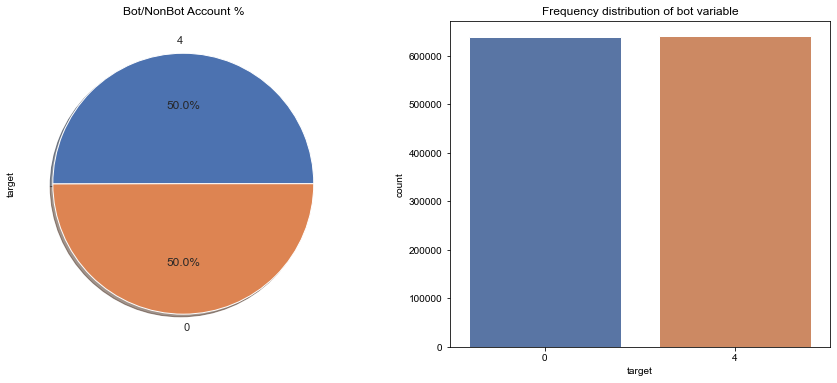

In [10]:
# count plot on bot/human accounts
f,ax=plt.subplots(1,2,figsize=(15,6))
sns.set_theme(style="darkgrid")
ax[0] = temp['target'].value_counts().plot.pie(explode=[0,0],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Bot/NonBot Account %')

ax[1] = sns.countplot(x="target", data=temp)
ax[1].set_title("Frequency distribution of bot variable")

plt.show()

In [11]:
# dropped the irrelevant columns that will not be used in sentiment analysis
temp.drop(['date','flag','username', 'id'], axis=1, inplace=True)
temp.head()

,target,tweet
128037,0,Oh really don't wanna be awake
491755,0,Trying to amuse my cousin. It's not working! a...
470924,0,@JonasAustralia i wanted to win! congrats to ...
491263,0,That's it!! I can't take it no more!! After su...
836489,4,@beckybootsx i hope your not drinking alcohol!...


In [12]:
emojiList = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed',':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy','@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused','<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink',';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

stopList = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an','and','any','are', 'as', 'at', 'be', 'because', 'been', 'before','being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do','does', 'doing', 'down', 'during', 'each','few', 'for', 'from','further', 'had', 'has', 'have', 'having', 'he', 'her', 'here','hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in','into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma','me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once','only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such','t', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them','themselves', 'then', 'there', 'these', 'they', 'this', 'those','through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was','we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom','why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre","youve", 'your', 'yours', 'yourself', 'yourselves']

In [13]:
from nltk.stem import WordNetLemmatizer

In [14]:
def preProcessData(tweetData):
    lemmatizer = WordNetLemmatizer()
    cleanedTweets = []
    text      = "[^a-zA-Z0-9]"
    punctuation   = r"(.)\1\1+"
    url = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userName       = '@[^\s]+'
    s = r"\1\1"
    
    for tweet in tweetData:
        tweet = tweet.lower()
        tweet = re.sub(url,' URL',tweet)
        for emoji in emojiList.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojiList[emoji])
        tweet = re.sub(userName,' USER', tweet)
        tweet = re.sub(text, " ", tweet)
        tweet = re.sub(punctuation, s, tweet)
        tweetwords = ''
        for word in tweet.split():
            if len(word)>1:
                word = lemmatizer.lemmatize(word)
                tweetwords += (word+' ')
        cleanedTweets.append(tweetwords)
        
    return cleanedTweets

In [15]:
cleanedText = preProcessData(temp['tweet'])

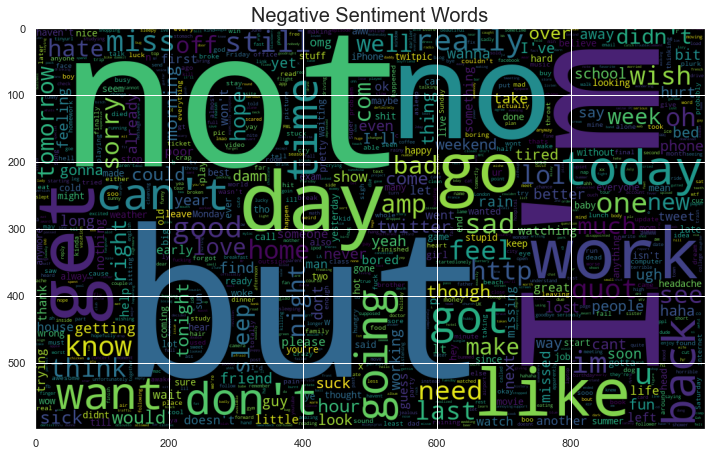

In [30]:
negative_tweets = " ".join([tweet for tweet in temp[temp.target==0]['tweet']])
wc = WordCloud(max_words=1000,stopwords = stopList, width=1000, height=600, collocations=False)
plt.figure(figsize=(12,12))
plt.imshow(wc.generate(negative_tweets))
plt.title('Negative Sentiment Words',fontsize=20)
plt.show()

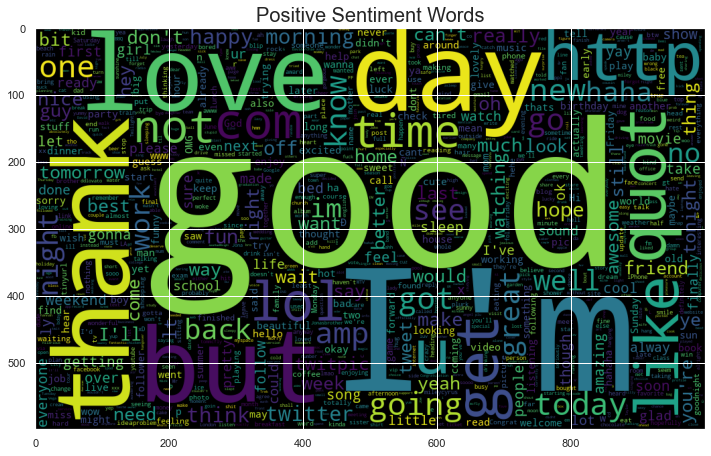

In [32]:
positive_tweets = " ".join([tweet for tweet in temp[temp.target==4]['tweet']])
wc = WordCloud(max_words=1000,stopwords = stopList, width=1000, height=600, collocations=False)
plt.figure(figsize=(12,12))
plt.imshow(wc.generate(positive_tweets))
plt.title('Positive Sentiment Words',fontsize=20)
plt.show()

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(cleanedText, temp['target'],test_size = 0.3, random_state = 0)

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=50000)
vectorizer.fit(X_train)
print('No. of feature words: ', len(vectorizer.get_feature_names()))

No. of feature words:  50000


C:\Users\patel\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [36]:
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report 
import seaborn as sns

def model(model):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    confusionMatrix = confusion_matrix(y_test, y_pred)
    catego = ['Negative', 'Positive']
    groupNms = ['True Neg', 'False Pos','False Neg','True Pos']  
    percentages = ['{0:.2%}'.format(value) for value in confusionMatrix.flatten() / np.sum(confusionMatrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(groupNms,percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(confusionMatrix, annot = labels, cmap = 'Blues',fmt = '',xticklabels = catego, yticklabels = catego)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.83      0.82      0.83    192430
           4       0.82      0.84      0.83    191570

    accuracy                           0.83    384000
   macro avg       0.83      0.83      0.83    384000
weighted avg       0.83      0.83      0.83    384000



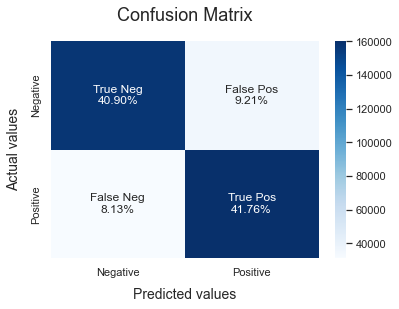

In [38]:
LRmodel = LogisticRegression(C=2, max_iter=1000, n_jobs=1)
LRmodel.fit(X_train, y_train)
model(LRmodel)

In [39]:
file = open('Sentiment.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

In [41]:
model = pickle.load(open(r'C:\Users\patel\OneDrive\Desktop\KDDM\Project\Sentiment.pickle', 'rb'))
def manualTest(vectoriser, model, text):
    textdata = vectorizer.transform(preProcessData(text))
    sentiment = model.predict(textdata)
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,4], ["Negative","Positive"])
    return df

In [42]:
import tweepy
from tweepy import OAuthHandler

consumer_key="qrbvg9yW3oNQ9QO95SM31FcWr"
consumer_secret="B88u2Rh1t0watdxyDjn4toE63GaSpDft78B5uKlgOV3h7mbWu0"
access_token="1363755308309381123-AVyYyk0HC6NdwyA4No06oNK4jUFX8o"
access_token_secret="tIH7A7bObvCC22voUHg6qfHjx87osBBWEuuoxFle3Wqzx"
	
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

In [43]:
posts = api.user_timeline(screen_name="KyivIndependent", count = 50, tweet_mode="extended")
listTweets=[] 
i=1

for tweet in posts[:50]:
    listTweets.append(tweet.full_text) 
    i=i+1

listTweets

['⚡️ EU official expects sixth package of sanctions against Russia this week.\n\nEuropean Commission Vice President Vera Jourova said that the most significant discussions are on banning Russian oil imports. She added that banking sector sanctions are highly likely to be accepted.',
 'The SBU called this "fantasies" and said that Solovyov would be "tried by international courts for his Goebbels-style murderous propaganda."',
 "⚡️ Ukrainian intelligence denies plans to kill Russian propagandist Vladimir Solovyov. \n\nRussia's Federal Security Service (FSB) said on April 25 that the Security Service of Ukraine (SBU) had hired neo-Nazis to plot his assassination.",
 '⚡️ Official says 26,397 internally displaced persons registered in Kyiv.\n\nThe number of IDPs in Kyiv has risen by more than 9,000 people over the past week, Kyiv Deputy Mayor Maryna Khonda said on April 25.',
 '⚡️ 3 civilians killed by Russian shelling in Kharkiv Oblast.\n\nThe shelling took place on April 25 in the village

In [45]:
print("Twitter User: KyivIndependent")
df = manualTest(vectorizer, model, listTweets)
print(df.head())

positiveCount = 0
negativeCount = 0

i = 0
for ind in df.index:
    if df['sentiment'][ind] == "Positive":
        positiveCount += 1
    else:
        negativeCount += 1
    
    i=i+1
    
print("\nPostitive Tweet Count: ",positiveCount)
print("Negative Tweet Count: ", negativeCount)

Twitter User: KyivIndependent
                                                text sentiment
0  ⚡️ EU official expects sixth package of sancti...  Positive
1  The SBU called this "fantasies" and said that ...  Negative
2  ⚡️ Ukrainian intelligence denies plans to kill...  Positive
3  ⚡️ Official says 26,397 internally displaced p...  Negative
4  ⚡️ 3 civilians killed by Russian shelling in K...  Negative

Postitive Tweet Count:  22
Negative Tweet Count:  28


In [46]:
test2 = api.user_timeline(screen_name="POTUS", count = 20, tweet_mode="extended")
testlist2=[] 
i2=1
for tweet2 in test2[:20]:
    testlist2.append(tweet2.full_text) 
    i=i+1

testlist2

['In my State of the Union address, I announced that we would propose expanding disability and health benefits to veterans suffering from nine rare respiratory cancers.\n\nToday, the VA is delivering on that promise and upholding our sacred obligation to care for our veterans.',
 'It’s time we treat addiction like any other disease. And at the same time, we are disrupting drug traffickers’ financial networks, supply chains, and delivery routes, including on the internet. https://t.co/fTQlLMa2Vm',
 'Congratulations to @EmmanuelMacron on his re-election. France is our oldest ally and a key partner in addressing global challenges. I look forward to our continued close cooperation — including on supporting Ukraine, defending democracy, and countering climate change.',
 'During his historic tenure in the Senate, Orrin Hatch was a leader of deep faith who looked out for the people who often didn’t have a voice in our laws.\n\nJill and I are saddened to learn of his passing and we send our de

In [48]:
print("Twitter User: POTUS")
test2df = manualTest(vectorizer, model, testlist2)
print(test2df.head())

positiveCountt2 = 0
negativeCountt2 = 0

i2 = 0
for ind in test2df.index:
    if test2df['sentiment'][ind] == "Positive":
        positiveCountt2 += 1
    else:
        negativeCountt2 += 1
    
    i2=i2+1
    
print("\nPostitive Tweet Count: ",positiveCountt2)
print("Negative Tweet Count: ", negativeCountt2)

Twitter User: POTUS
                                                text sentiment
0  In my State of the Union address, I announced ...  Negative
1  It’s time we treat addiction like any other di...  Positive
2  Congratulations to @EmmanuelMacron on his re-e...  Positive
3  During his historic tenure in the Senate, Orri...  Negative
4  Two months after Putin launched an unprovoked ...  Positive

Postitive Tweet Count:  15
Negative Tweet Count:  5


In [49]:
test3 = api.user_timeline(screen_name="StoryBots", count = 50,  tweet_mode="extended")
testlist3=[] 
i=1
for tweet in test3[:50]:
    testlist3.append(tweet.full_text) 
    i=i+1

testlist3


['In 2022, follow @NetflixFamily to keep up with StoryBots and all your kids’ favorite shows. And don’t forget all the great offerings for after the kids are in bed. (If you haven’t seen Squid Game yet, you’ve got some catching up to do!)\n#StoryBots #NetflixFamily #2022 https://t.co/BM7gNSeEXu',
 'As 2021 draws to a close, the StoryBots wish you a happy New Year and the best of everything in 2022!\n#StoryBots #HappyNewYear https://t.co/3tbQR1F2Dh',
 'This great StoryBots splash page by 9-year-old Blake somehow got left out of our Fan Art Friday posts. Sorry for the delay, Blake, but great job!\n#StoryBots #Kidart https://t.co/c98JoMespw',
 'On this day in 1924, astronomer Edwin Hubble announced the discovery of other galaxies. Wow, that’s some discovery! Someone should name a telescope after him or something.\n#StoryBots #todayinhistory #EdwinHubble https://t.co/QcKXuO01zF',
 'Today is Tick Tock Day, a time to remember that the clock is ticking toward the end of the year. What do you 

In [50]:
print("Twitter User: StoryBots")
testdf3 = manualTest(vectorizer, model, testlist3)
print(testdf3.head())

positiveCountt3 = 0
negativeCountt3 = 0

i = 0
for ind in testdf3.index:
    if testdf3['sentiment'][ind] == "Positive":
        positiveCountt3 += 1
    else:
        negativeCountt3 += 1
    
    i=i+1
    
print("\nPostitive Tweet Count: ", positiveCountt3)
print("Negative Tweet Count: ", negativeCountt3)

Twitter User: StoryBots
                                                text sentiment
0  In 2022, follow @NetflixFamily to keep up with...  Positive
1  As 2021 draws to a close, the StoryBots wish y...  Positive
2  This great StoryBots splash page by 9-year-old...  Positive
3  On this day in 1924, astronomer Edwin Hubble a...  Positive
4  Today is Tick Tock Day, a time to remember tha...  Negative

Postitive Tweet Count:  47
Negative Tweet Count:  3
